In [ ]:
!pip install sentence_transformers datasets lancedb sf-hamilton[visualization] -qU

# How to use Lancedb with NER semantic search \[for RAG\]
In this post we’ll walk through an example pipeline written in Hamilton to embed some text, and also capture extra metadata about the text that can be used when deciding what data to pull for RAG. This is a form of "semantic search" and we use LanceDB to store our data and query over it.

Why capture, or rather extract (as you’ll see), extra metadata? Because you can use it to filter results to improve accuracy. You’ll need more than just cosine similarity to achieve a quality system [\[1\]](https://jxnl.co/writing/2024/05/11/low-hanging-fruit-for-rag-search/). [Named Entity Recognition (NER)](https://en.wikipedia.org/wiki/Named-entity_recognition) is just one approach to gather extra metadata from text that can be used for this purpose.

> In short, we use the NER model to further filter the semantic search results. The predicted named entities are used as  “filters” (pre or post) to filter the vector search results. This is particularly helpful if you want to restrict the search to records that contain information about the named entities that are also found within the query.

In this notebook we'll build out a processing pipeline and walkthrough the code to:

1. Extract named entities from text.
2. Store them in a LanceDB as metadata (alongside embedding vectors).
3. We extract named entities from incoming queries and use them to filter and search only through records containing these named entities.


Let's get started.

In [1]:
# load the jupyter magic
%load_ext hamilton.plugins.jupyter_magic

# Load the data
Here we first start by loading the dataset from huggingface.

Here we use a DataLoader that Hamilton comes with to load the dataset for us. We could do some filtering within the loading function, but instead choose to break it out into another function to sample and augment the loaded dataset.

Note about the sampling below, in real life we’d use the full data set. We sample here to make this example tractable to run. Otherwise we modify the data set in the following way:
1. We remove documents with empty titles and text.
2. We truncate text to only be the first 1000 characters. This is to limit the dataset size, but to also make it fit into our the context window that creates our embeddings. In real life you’d probably want to process the entire text somehow, or create separate embeddings for different text chunks, etc.
3. Further to simplify things, we combine the title & text into a single field for NER & embedding purposes. We assume the title and the first 1000 characters of text contain enough information to get a general gist of the document to create an embedding and get relevant entities out. 


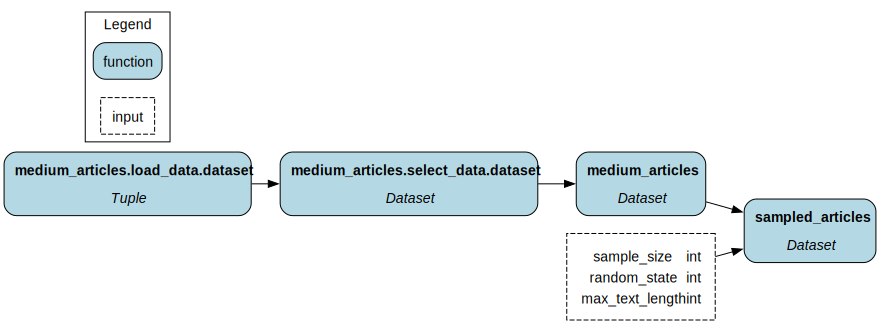

In [2]:
%%incr_cell_to_module ner_module -i 1 --display

from datasets import Dataset
from hamilton.function_modifiers import load_from, save_to, source, value

@load_from.hf_dataset(
    path=value("fabiochiu/medium-articles"),
    data_files=value("medium_articles.csv"),
    split=value("train"),
)
def medium_articles(dataset: Dataset) -> Dataset:
    """Loads medium dataset into a hugging face dataset"""
    return dataset


def sampled_articles(
    medium_articles: Dataset,
    sample_size: int = 104,
    random_state: int = 32,
    max_text_length: int = 1000,
) -> Dataset:
    """Samples the articles and does some light transformations.
    Transformations:
     - selects the first 1000 characters of text. This is for performance here. But in real life you'd \
     do something for your use case.
      - Joins article title and the text to create one text string.
    """
    # Filter out entries with NaN values in 'text' or 'title' fields
    dataset = medium_articles.filter(
        lambda example: example["text"] is not None and example["title"] is not None
    )

    # Shuffle and take the first 10000 samples
    dataset = dataset.shuffle(seed=random_state).select(range(sample_size))

    # Truncate the 'text' to the first 1000 characters
    dataset = dataset.map(lambda example: {"text": example["text"][:max_text_length]})

    # Concatenate the 'title' and truncated 'text'
    dataset = dataset.map(lambda example: {"title_text": example["title"] + ". " + example["text"]})
    return dataset

# Create the NER tokenizer and model
We now can add to our pipeline loading the tokenizer and model that will extract entities for us from text. The NER model here is finetuned on a BERT-base model.  All the models are loaded from huggingface.


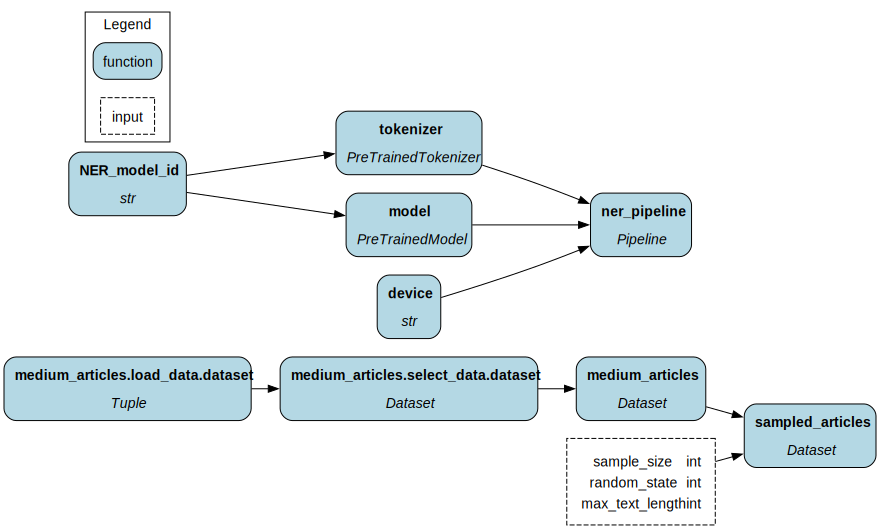

In [3]:
%%incr_cell_to_module ner_module -i 2 --display

import torch
from transformers import (
    AutoModelForTokenClassification,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    pipeline,
)
from transformers.pipelines import base

def device() -> str:
    """Whether this is a CUDA or CPU enabled device."""
    return "cuda" if torch.cuda.is_available() else "cpu"


def NER_model_id() -> str:
    """Model ID to use
    To extract named entities, we will use a NER model finetuned on a BERT-base model.
    The model can be loaded from the HuggingFace model hub.
    Use `overrides={"NER_model_id": VALUE}` to switch this without changing code.
    """
    return "dslim/bert-base-NER"


def tokenizer(NER_model_id: str) -> PreTrainedTokenizer:
    """Loads the tokenizer for the NER model ID from huggingface"""
    return AutoTokenizer.from_pretrained(NER_model_id)


def model(NER_model_id: str) -> PreTrainedModel:
    """Loads the NER model from huggingface"""
    return AutoModelForTokenClassification.from_pretrained(NER_model_id)


def ner_pipeline(
    model: PreTrainedModel, tokenizer: PreTrainedTokenizer, device: str
) -> base.Pipeline:
    """Loads the tokenizer and model into a NER pipeline. That is it combines them."""
    device_no = torch.cuda.current_device() if device == "cuda" else None
    return pipeline(
        "ner", model=model, tokenizer=tokenizer, aggregation_strategy="max", device=device_no
    )

In [4]:
# this is what the NER pipeline produces
text = "The Mars Rover from NASA reached the red planet yesterday."
ner_pipeline(model(NER_model_id()), tokenizer(NER_model_id()), "cpu")([text])

/Users/stefankrawczyk/.pyenv/versions/3.10.4/envs/ner-example-py310/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model

[[{'entity_group': 'ORG',
   'score': 0.9978863,
   'word': 'Mars Rover',
   'start': 4,
   'end': 14},
  {'entity_group': 'ORG',
   'score': 0.99731904,
   'word': 'NASA',
   'start': 20,
   'end': 24}]]

# Create the embedding model
Next we load the retriever model that will create embeddings, i.e. a vector/list of floats, that encode our text. Specifically it will embed passages (article title + first 1000 characters) and also be used to create an embedding from the search query that will be provided at inference time. It creates embeddings such that queries and passages with similar meanings are close in the vector space. We will use a sentence-transformer model as our retriever. The model can be loaded using the following code.

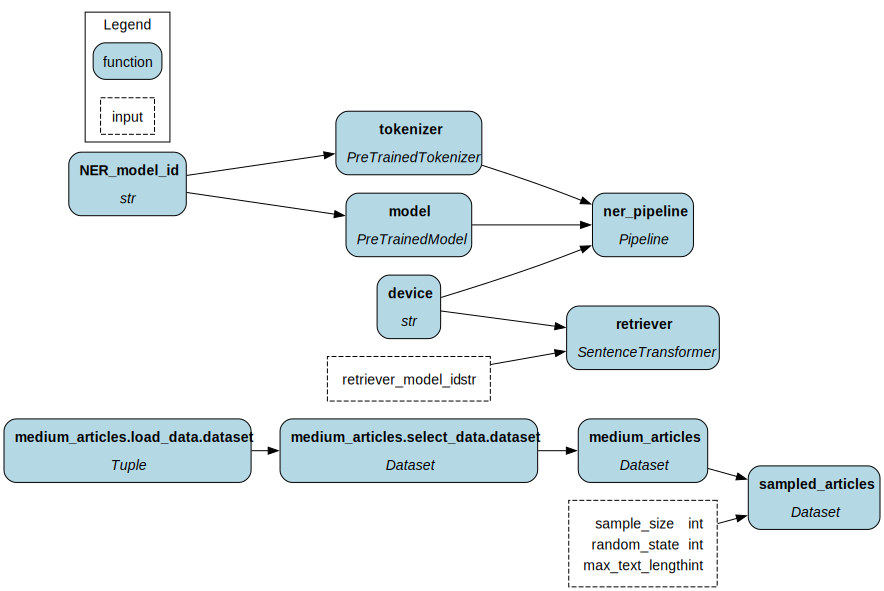

In [5]:
%%incr_cell_to_module ner_module -i 3 --display
from sentence_transformers import SentenceTransformer

def retriever(
    device: str, retriever_model_id: str = "flax-sentence-embeddings/all_datasets_v3_mpnet-base"
) -> SentenceTransformer:
    """Our retriever model to create embeddings.

    A retriever model is used to embed passages (article title + first 1000 characters)
     and queries. It creates embeddings such that queries and passages with similar
     meanings are close in the vector space. We will use a sentence-transformer model
      as our retriever. The model can be loaded as follows:
    """
    return SentenceTransformer(retriever_model_id, device=device)

In [6]:
# what the embedding model produces -- just show first 10 numbers
retriever("cpu").encode(["this is some text"])[0][0:10]

/Users/stefankrawczyk/.pyenv/versions/3.10.4/envs/ner-example-py310/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


array([ 0.03609628, -0.03315403,  0.00881905,  0.04301339,  0.00257134,
       -0.00996292,  0.02379813,  0.03957068, -0.03063051, -0.00725629],
      dtype=float32)

# Extracting entities & creating embeddings
Next let’s put this all together to extract entities & embed the documents.

We do this by using Huggingface dataset’s map functionality. Using this ensures that data can be loaded into batches to ensure that data hungry GPUs are appropriately fed with data. What you need to provide to this function is a function that contains the logic you want to apply to it. So below we create some helper functions for that purpose. This also helps ensure unit testability, while also keeping the code clean. We then wire these helper functions up to the map functions to create the vector embedding and named_entities columns on the dataset. 

We then prepare this for loading into lancedb by using the `@save_to` data saver. This uses batching to write chunks of the dataset to lancedb.

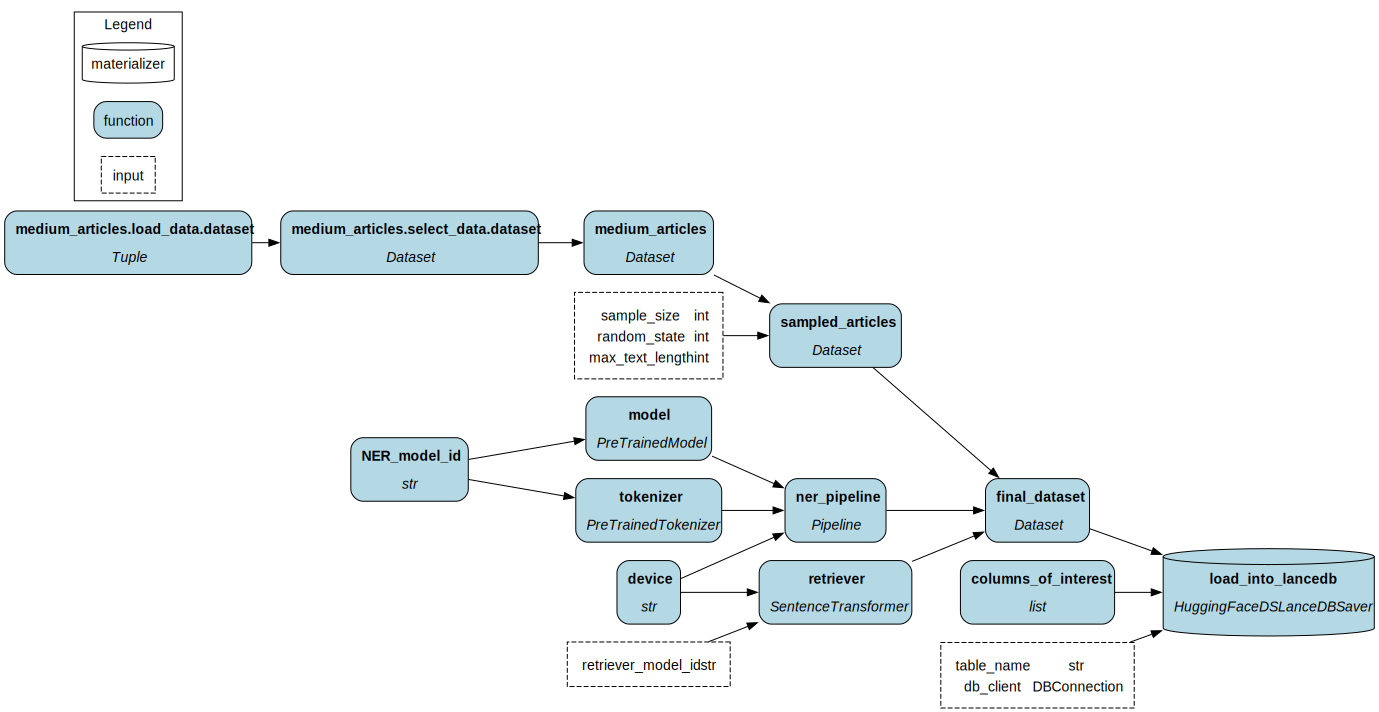

In [7]:
%%incr_cell_to_module ner_module -i 4 --display
from datasets.formatting.formatting import LazyBatch
from typing import Union

def _extract_named_entities_text(
    title_text_batch: Union[LazyBatch, list[str]], _ner_pipeline
) -> list[list[str]]:
    """Helper function to extract named entities given a batch of text."""
    # extract named entities using the NER pipeline
    extracted_batch = _ner_pipeline(title_text_batch)
    # this should be extracted_batch = dataset.map(ner_pipeline)
    entities = []
    # loop through the results and only select the entity names
    for text in extracted_batch:
        ne = [entity["word"] for entity in text]
        entities.append(ne)
    _named_entities = [list(set(entity)) for entity in entities]
    return _named_entities


def _batch_map(dataset: LazyBatch, _retriever, _ner_pipeline) -> dict:
    """Helper function to created the embedding vectors and extract named entities"""
    title_text_list = dataset["title_text"]
    emb = _retriever.encode(title_text_list)
    _named_entities = _extract_named_entities_text(title_text_list, _ner_pipeline)
    return {
        "vector": emb,
        "named_entities": _named_entities,
    }


def columns_of_interest() -> list[str]:
    """The columns we expect to pull from the dataset to be saved to lancedb"""
    return ["vector", "named_entities", "title", "url", "authors", "timestamp", "tags"]


@save_to.lancedb(
    db_client=source("db_client"),
    table_name=source("table_name"),
    columns_to_write=source("columns_of_interest"),
    output_name_="load_into_lancedb",
)
def final_dataset(
    sampled_articles: Dataset,
    retriever: SentenceTransformer,
    ner_pipeline: base.Pipeline,
) -> Dataset:
    """The final dataset to be pushed to lancedb.

    This adds two columns:

     - vector -- the vector embedding
     - named_entities -- the names of entities extracted from the text
    """
    # goes over the data in batches so that the GPU can be properly utilized.
    final_ds = sampled_articles.map(
        _batch_map,
        batched=True,
        fn_kwargs={"_retriever": retriever, "_ner_pipeline": ner_pipeline},
        desc="extracting entities",
    )
    return final_ds

# Load data into lancedb

With our processing pipeline now ready, let's load some data into lancedb.

We'll do this by instantiating a driver to execute our pipeline.

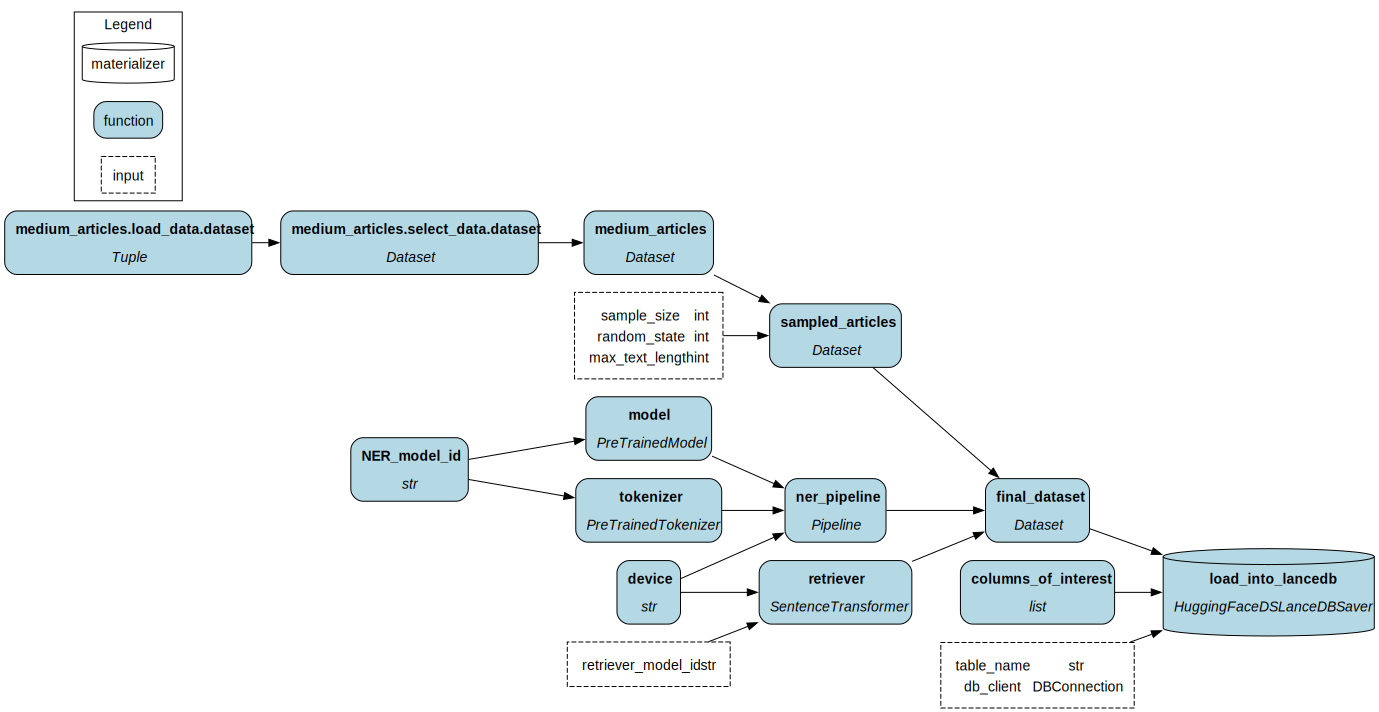

In [8]:
from hamilton import driver, lifecycle
dr = (
    driver.Builder()
    .with_config({})
    .with_modules(ner_module)
    .with_adapters(lifecycle.PrintLn())
    .build()
)
dr

In [9]:
# now we execute it - we specify the output that we want.
import lancedb
table_name = "medium_docs"
db_client =  lancedb.connect("./.lancedb")

results = dr.execute(
    ["load_into_lancedb"],
    inputs={"table_name": table_name, "db_client": db_client},
)
results

Executing node: columns_of_interest.
Finished debugging node: columns_of_interest in 609μs. Status: Success.
Executing node: medium_articles.load_data.dataset.
Finished debugging node: medium_articles.load_data.dataset in 1.87s. Status: Success.
Executing node: medium_articles.select_data.dataset.
Finished debugging node: medium_articles.select_data.dataset in 17.9μs. Status: Success.
Executing node: medium_articles.
Finished debugging node: medium_articles in 23.1μs. Status: Success.
Executing node: sampled_articles.
Finished debugging node: sampled_articles in 30ms. Status: Success.
Executing node: device.
Finished debugging node: device in 40.1μs. Status: Success.
Executing node: retriever.


/Users/stefankrawczyk/.pyenv/versions/3.10.4/envs/ner-example-py310/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Finished debugging node: retriever in 1.11s. Status: Success.
Executing node: NER_model_id.
Finished debugging node: NER_model_id in 17.9μs. Status: Success.
Executing node: model.


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Finished debugging node: model in 340ms. Status: Success.
Executing node: tokenizer.
Finished debugging node: tokenizer in 158ms. Status: Success.
Executing node: ner_pipeline.
Finished debugging node: ner_pipeline in 2.52ms. Status: Success.
Executing node: final_dataset.
Finished debugging node: final_dataset in 5.96s. Status: Success.
Executing node: load_into_lancedb.


writing to lancedb table medium_docs:   0%|          | 0/104 [00:00<?, ? examples/s]

Finished debugging node: load_into_lancedb in 215ms. Status: Success.


{'load_into_lancedb': {'db_meta': {'table_name': 'medium_docs'},
  'dataset_metadata': {'rows': 104,
   'columns': ['title',
    'text',
    'url',
    'authors',
    'timestamp',
    'tags',
    'title_text',
    'vector',
    'named_entities'],
   'size_in_bytes': 2087095068,
   'features': {'title': {'dtype': 'string', '_type': 'Value'},
    'text': {'dtype': 'string', '_type': 'Value'},
    'url': {'dtype': 'string', '_type': 'Value'},
    'authors': {'dtype': 'string', '_type': 'Value'},
    'timestamp': {'dtype': 'string', '_type': 'Value'},
    'tags': {'dtype': 'string', '_type': 'Value'},
    'title_text': {'dtype': 'string', '_type': 'Value'},
    'vector': {'feature': {'dtype': 'float32', '_type': 'Value'},
     '_type': 'Sequence'},
    'named_entities': {'feature': {'dtype': 'string', '_type': 'Value'},
     '_type': 'Sequence'}}}}}

# Querying for results

We can now query the DB. To do that let's create an inference portion of our pipeline.

We'll write a function to extract entities from the query, and then construct the appropriate lancedb query to
filter results only if there are named entities in common.

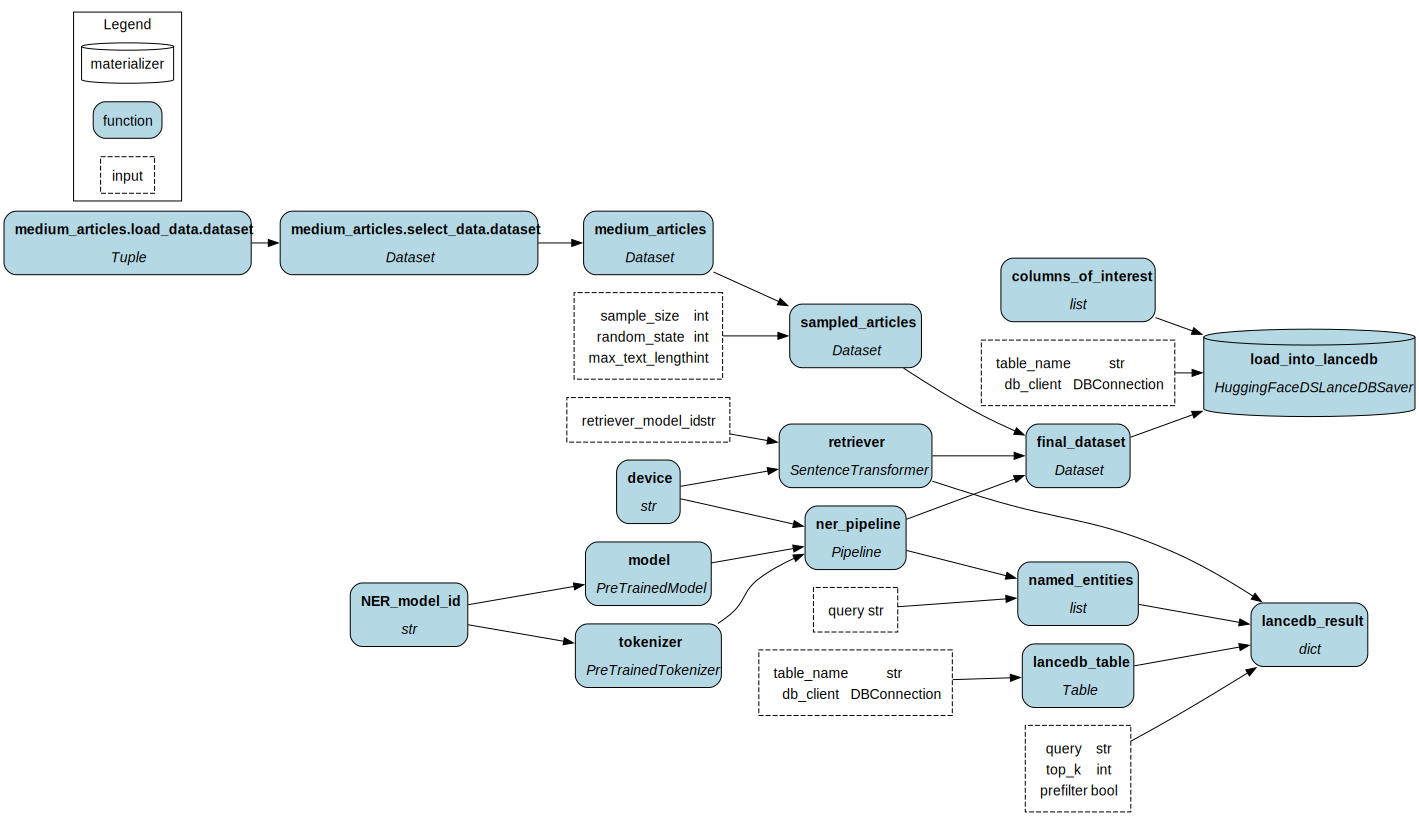

In [10]:
%%incr_cell_to_module ner_module -i 5 --display 

import lancedb
import numpy as np

def named_entities(query: str, ner_pipeline: base.Pipeline) -> list[str]:
    """The entities to extract from the query via the pipeline."""
    return _extract_named_entities_text([query], ner_pipeline)[0]

def lancedb_table(db_client: lancedb.DBConnection, table_name: str = "tw") -> lancedb.table.Table:
    """Table to query against"""
    tbl = db_client.open_table(table_name)
    return tbl


def lancedb_result(
    query: str,
    named_entities: list[str],
    retriever: SentenceTransformer,
    lancedb_table: lancedb.table.Table,
    top_k: int = 10,
    prefilter: bool = True,
) -> dict:
    """Result of querying lancedb.

    :param query: the query
    :param named_entities: the named entities found in the query
    :param retriever: the model to create the embedding from the query
    :param lancedb_table: the lancedb table to query against
    :param top_k: number of top results
    :param prefilter: whether to prefilter results before cosine distance
    :return: dictionary result
    """
    # create embeddings for the query
    query_vector = np.array(retriever.encode(query).tolist())

    # query the lancedb table
    query_builder = lancedb_table.search(query_vector, vector_column_name="vector")
    if named_entities:
        # applying named entity filter if something was returned
        where_clause = f"array_length(array_intersect({named_entities}, named_entities)) > 0"
        query_builder = query_builder.where(where_clause, prefilter=prefilter)
    result = (
        query_builder.select(["title", "url", "named_entities"])  # what to return
        .limit(top_k)
        .to_list()
    )
    # could rerank results here
    return {"Query": query, "Query Entities": named_entities, "Result": result}


# Execute some queries

We can now run a few queries against what's in lancedb.

In [11]:
dr_query = (
    driver.Builder()
    .with_config({})
    .with_modules(ner_module)
    .with_adapters(lifecycle.PrintLn())
    .build()
)
dr_query.execute(["lancedb_result"], 
                 inputs={"table_name": table_name, 
                         "query": "What is the future of autonomous vehicles?",
                         "db_client": db_client
                        })

Executing node: NER_model_id.
Finished debugging node: NER_model_id in 179μs. Status: Success.
Executing node: model.


/Users/stefankrawczyk/.pyenv/versions/3.10.4/envs/ner-example-py310/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model

Finished debugging node: model in 584ms. Status: Success.
Executing node: tokenizer.
Finished debugging node: tokenizer in 152ms. Status: Success.
Executing node: device.
Finished debugging node: device in 42μs. Status: Success.
Executing node: ner_pipeline.
Finished debugging node: ner_pipeline in 2.02ms. Status: Success.
Executing node: named_entities.
Finished debugging node: named_entities in 52.3ms. Status: Success.
Executing node: retriever.
Finished debugging node: retriever in 1.75s. Status: Success.
Executing node: lancedb_table.
Finished debugging node: lancedb_table in 429μs. Status: Success.
Executing node: lancedb_result.
Finished debugging node: lancedb_result in 87.1ms. Status: Success.


{'lancedb_result': {'Query': 'What is the future of autonomous vehicles?',
  'Query Entities': [],
  'Result': [{'title': 'Automated large scale data generation for autonomous vehicle',
    'url': 'https://medium.com/mars-auto/automated-large-scale-data-generation-for-autonomous-vehicle-59de8b26357e',
    'named_entities': ['Busan', 'Seoul'],
    '_distance': 1.1834863424301147},
   {'title': 'How to Scale Up Tech Solutions and Amplify Their Sustainability Impacts',
    'url': 'https://medium.com/ksapa/how-to-scale-up-tech-solutions-and-amplify-their-sustainability-impacts-5124b192294d',
    'named_entities': ['Augmented Reality',
     'AI',
     'Solutions',
     'IoT',
     'Machine Learning',
     'Internet of Things',
     'Virtual Reality',
     'Global Goals',
     'AR'],
    '_distance': 1.3800410032272339},
   {'title': 'Tech vs. Regulators: A Case In Point',
    'url': 'https://medium.com/@nimishaagr/tech-vs-regulators-a-case-in-point-3959b8c81d27',
    'named_entities': ['UK'

In [12]:
dr_query.execute(
    ["lancedb_result"], 
    inputs={
        "table_name": table_name, 
        "query": "Who is Joe Biden?",
        "db_client": db_client
    }
)

Executing node: NER_model_id.
Finished debugging node: NER_model_id in 309μs. Status: Success.
Executing node: model.


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Finished debugging node: model in 405ms. Status: Success.
Executing node: tokenizer.
Finished debugging node: tokenizer in 133ms. Status: Success.
Executing node: device.
Finished debugging node: device in 39.3μs. Status: Success.
Executing node: ner_pipeline.
Finished debugging node: ner_pipeline in 1.9ms. Status: Success.
Executing node: named_entities.
Finished debugging node: named_entities in 26.4ms. Status: Success.
Executing node: retriever.
Finished debugging node: retriever in 1.28s. Status: Success.
Executing node: lancedb_table.
Finished debugging node: lancedb_table in 371μs. Status: Success.
Executing node: lancedb_result.
Finished debugging node: lancedb_result in 64.9ms. Status: Success.


{'lancedb_result': {'Query': 'Who is Joe Biden?',
  'Query Entities': ['Joe Biden'],
  'Result': [{'title': 'Not the neighborhood he left: Biden’s international challenge',
    'url': 'https://medium.com/@info-63603/not-the-neighborhood-he-left-bidens-international-challenge-d023f7ed26d0',
    'named_entities': ['United States',
     'Joe Biden',
     'Russia',
     'American',
     'Trump',
     'Biden',
     'China'],
    '_distance': 0.9555794596672058}]}}

In [35]:
dr_query.execute(
    ["lancedb_result"], 
    inputs={
        "table_name": table_name, 
        "query": "How Data is changing the world?",
        "db_client": db_client
    }
)

Executing node: NER_model_id.
Finished debugging node: NER_model_id in 99.9μs. Status: Success.
Executing node: model.


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Finished debugging node: model in 273ms. Status: Success.
Executing node: tokenizer.
Finished debugging node: tokenizer in 130ms. Status: Success.
Executing node: device.
Finished debugging node: device in 25.3μs. Status: Success.
Executing node: ner_pipeline.
Finished debugging node: ner_pipeline in 1.78ms. Status: Success.
Executing node: named_entities.
Finished debugging node: named_entities in 27.5ms. Status: Success.
Executing node: retriever.
Finished debugging node: retriever in 1.15s. Status: Success.
Executing node: lancedb_table.
Finished debugging node: lancedb_table in 149μs. Status: Success.
Executing node: lancedb_result.
Finished debugging node: lancedb_result in 27.1ms. Status: Success.


{'lancedb_result': {'Query': 'How Data is changing the world?',
  'Query Entities': ['Data'],
  'Result': []}}

# Summary
In this notebook we:

1. incrementally created a pipeline to process medium articles
2. the pipeline extracted named entities from the articles
3. the pipeline created vectors embeddings from text
4. we pushed all the data into lanceDB to then query against

# Next steps to combine with RAG
We now have a database that can query over medium articles via cosine similarity, as well as
using extra metadata, in this case named entities referenced in the text, extracted to help us filter results.

With this general blueprint, you can then play around with and modify what context you would
retrieve given a user query to then populate a prompt with to send to an LLM.

For example, we could take the URLs returned and load the document that way, or 
adjust what is stored in lancedb and return text stored there, etc.  If you'd 
like to build a conversational agent, we refer you to Hamilton's sister framework
[Burr](https://github.com/dagworks-inc/burr) that can help you build, curate,
and debug your application.


# Extensions
There's many ways to extend this pipeline. Here are a few ideas:

1. Use a different NER model.
2. Use a different embedding model.
3. Use a different database.
4. Use more data to filter the results by, e.g. ACLs if applicable.
5. Use query expansion to improve the results by expanding the extracted entities from the query.
6. Use a re-ranking algorithm to rank the results.
7. Work on document chunking to optimize for your particular RAG use case.